In [1]:
import pandas as pd
import os
import csv
import ast
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import binarize


In [2]:
file_names = os.listdir('../../Preprocess/GadgetX-NewMDCLUSTER-1/combined-csv/')

In [3]:
dataframes = []
for file_name in file_names:
    df = pd.read_csv(f'../../Preprocess/GadgetX-NewMDCLUSTER-1/combined-csv/{file_name}')
    dataframes.append(df)

In [4]:
all_data = pd.concat(dataframes)

# Convert the 'ProgenitorsID' column from string to list
all_data['ProgenitorsID'] = all_data['ProgenitorsID'].apply(ast.literal_eval)

# Sort the snapshots in descending order
all_data = all_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

In [5]:
training_data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots-reduced/v2/training_data.csv')

In [6]:
len(training_data.index)

658908

In [7]:
training_data.head()

,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,progenitor_Phi0,progenitor_cNFW,progenitor_ID,progenitor_numProgenitors,progenitor_ProgenitorsID,progenitor_redshift,progenitor_snapshot,rel_location,rel_velocity,Is_Progenitor
0,122000000000001,0,7.692290e+10,145,499906.668493,500198.003224,499913.299084,-568.82,-1836.12,-1626.31,...,15569.3,-1.0000,121000000006488,0,[-1],0.168,121,3017.914974,3642.293649,0
1,122000000000001,0,7.692290e+10,145,499906.668493,500198.003224,499913.299084,-568.82,-1836.12,-1626.31,...,169494.0,26.9302,121000000000462,1,[120000000000389],0.168,121,2706.483903,3977.063611,0
2,88000000000275,0,1.375210e+10,171,501803.625375,492068.283260,489277.470857,-169.17,-125.75,672.46,...,62344.6,-1.0000,87000000002688,1,[81000000001891],1.480,87,142.768232,100.982342,1
3,0,0,8.480220e+10,101,482164.053963,499916.727726,496461.100303,503.21,-360.71,-135.91,...,100883.0,26.6265,100000000004152,1,[99000000004149],0.858,100,4135.861245,659.412098,0
4,0,0,4.867230e+10,53,505733.966827,491471.586319,508446.191366,-1137.31,634.72,-454.39,...,20427.0,15.9005,103000000008841,1,[102000000009364],0.738,103,345.708750,45.263222,1


In [8]:
select_features = ['rel_location',
                    'rel_velocity',
                    'progenitor_snapshot',
                    'progenitor_redshift',
                    'numProgenitors',
                    'cNFW',
                    'lambda',
                    'progenitor_lambda',
                    'Rmax',
                    'nbins',
                    'progenitor_nbins',
                    'progenitor_com_offset',
                    'r2',
                    'progenitor_SurfP',
                    'ovdens',
                    'SurfP',
                    'progenitor_cNFW',
                    'com_offset' ,
                    'Is_Progenitor']

# Select only the defined features from the training data
training_data = training_data[select_features]

training_data.head()


,rel_location,rel_velocity,progenitor_snapshot,progenitor_redshift,numProgenitors,cNFW,lambda,progenitor_lambda,Rmax,nbins,progenitor_nbins,progenitor_com_offset,r2,progenitor_SurfP,ovdens,SurfP,progenitor_cNFW,com_offset,Is_Progenitor
0,3017.914974,3642.293649,121,0.168,1,23.7411,0.038054,0.060229,11.46,9,7,1.32888,1.61862,-3.664760e+12,600.43,-1.076870e+14,-1.0000,2.88480,0
1,2706.483903,3977.063611,121,0.168,1,23.7411,0.038054,0.081686,11.46,9,16,7.61115,1.61862,-2.892620e+15,600.43,-1.076870e+14,26.9302,2.88480,0
2,142.768232,100.982342,87,1.480,1,-1.0000,0.018961,0.067489,1.35,10,11,1.82446,4.08320,-5.028770e+14,109200.96,-8.333680e+13,-1.0000,1.11930,1
3,4135.861245,659.412098,100,0.858,1,20.5125,0.013466,0.024705,7.94,8,10,12.59597,18.34375,-2.460620e+14,181.88,-2.549840e+13,26.6265,13.42195,0
4,345.708750,45.263222,103,0.738,1,29.5350,0.050582,0.053193,5.98,7,7,6.64826,29.50998,-2.529360e+13,163.18,-7.739930e+12,15.9005,5.75129,1


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = training_data.drop('Is_Progenitor', axis=1)
y = training_data['Is_Progenitor']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:


weights = {0: 1, 1: 20}
# Train the Random Forest model
model = RandomForestClassifier(class_weight=weights, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Change the threshold here
threshold = 0.5
y_pred = binarize(y_pred_prob.reshape(1, -1), threshold=threshold)[0]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65910
           1       1.00      1.00      1.00     65872

    accuracy                           1.00    131782
   macro avg       1.00      1.00      1.00    131782
weighted avg       1.00      1.00      1.00    131782



In [10]:
import joblib

In [ ]:
joblib.dump(model, "model/random-forest-128-selected-features.joblib")

In [11]:
model = joblib.load("model/random-forest-128-selected-features.joblib")

-------------------------------------------

# Functions

In [15]:
import warnings
warnings.filterwarnings('ignore')

def create_merger_tree(halo, model, scaler, snapshot_dict, threshold=0.5, cache=None, processed_snapshots=None):
    if cache is None:
        cache = {}
    if processed_snapshots is None:
        processed_snapshots = set()

    merger_tree = [halo]
    
    select_features = ['rel_location',
                        'rel_velocity',
                        'progenitor_snapshot',
                        'progenitor_redshift',
                        'numProgenitors',
                        'cNFW',
                        'lambda',
                        'progenitor_lambda',
                        'Rmax',
                        'nbins',
                        'progenitor_nbins',
                        'progenitor_com_offset',
                        'r2',
                        'progenitor_SurfP',
                        'ovdens',
                        'SurfP',
                        'progenitor_cNFW',
                        'com_offset']
    
    previous_snapshot = halo['snapshot'] - 1
    
    # Check if previous halos have been cached
    if previous_snapshot not in snapshot_dict:
        return merger_tree
    
    previous_halos = snapshot_dict[previous_snapshot]
    feature_vectors = []
    halo_pairs = []
    
    for _, previous_halo in previous_halos.iterrows():
        # Create the feature vector for the current pair of halos
        pair = pd.concat([halo, previous_halo.rename(lambda x: f'progenitor_{x}')])

        # calculate relative location and velocity
        rel_location = sum((pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2 for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']))
        rel_velocity = sum((pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2 for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']))
        
        pair['rel_location'] = np.sqrt(rel_location)
        pair['rel_velocity'] = np.sqrt(rel_velocity)

        feature_vector = pair[select_features]
        feature_vectors.append(scaler.transform(feature_vector.values.reshape(1, -1)))
        halo_pairs.append(previous_halo)
    
    # Batch predict
    pred_probs = model.predict_proba(np.vstack(feature_vectors))[:, 1]
    predictions = binarize(pred_probs.reshape(-1, 1), threshold=threshold).flatten()
    
    for pred, previous_halo in zip(predictions, halo_pairs):
        if pred == 1:
            merger_tree.append(previous_halo)
            # Check cache before making a recursive call
            if previous_halo.name not in cache:
                cache[previous_halo.name] = create_merger_tree(previous_halo, model, scaler, snapshot_dict, threshold, cache, processed_snapshots)
            merger_tree += cache[previous_halo.name]
                
    return merger_tree


def track_halo_history_predicted(halo, model, scaler, all_data):
    snapshot_dict = {snap: df for snap, df in all_data.groupby('snapshot')}
    history = create_merger_tree(halo, model, scaler, snapshot_dict)
    return pd.DataFrame(history)

def track_halo_history_real(halo_id, snapshot, df):
    halo = df[(df['ID'] == halo_id) & (df['snapshot'] == snapshot)]
    if len(halo) == 0:
        return pd.DataFrame()
    progenitors = halo.iloc[0]['ProgenitorsID']
    history = halo
    if progenitors:
        for progenitor in progenitors:
            if progenitor == -1:  # Ignore the progenitor if its ID is -1
                continue
            progenitor_history = track_halo_history_real(progenitor, snapshot - 1, df)
            history = pd.concat([history, progenitor_history])
    return history


def plot_halo_history(halo_id, real_halo_history, predicted_halo_history, title):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    id_to_point_real = {row['ID']: (row['redshift'], row['Mvir'] / 1e11) for _, row in real_halo_history.iterrows()}
    id_to_point_predicted = {row['ID']: (row['redshift'], row['Mvir'] / 1e11) for _, row in predicted_halo_history.iterrows()}

    real_progenitors = {row['ID']: set(row['ProgenitorsID']) for _, row in real_halo_history.iterrows()}
    predicted_progenitors = {row['ID']: set(row['ProgenitorsID']) for _, row in predicted_halo_history.iterrows()}

    # Set the font dictionaries (for title and labels)
    font_title = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 25}
    font_axes = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 25}
    font_legend = {'size': 12}

    # Plot the real history first with zorder=2
    for id_to_point, halo_history, color, line_style, label in [(id_to_point_real, real_halo_history, 'red', '-', 'False Negative')]:
        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                for progenitor in row['ProgenitorsID']:
                    if progenitor == -1 or progenitor not in id_to_point:
                        continue
                    x_values = [id_to_point[group_id][0], id_to_point[progenitor][0]]
                    y_values = [id_to_point[group_id][1], id_to_point[progenitor][1]]
                    ax1.plot(x_values, y_values, line_style, color=color, alpha=0.7, zorder=2)
                point_color = 'orange' if row['ID'] == halo_id else color
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', linestyle=line_style, color=point_color, markersize=15, zorder=2)

    # Plot False Positives with zorder=1
    for group_id, group in predicted_halo_history.groupby('ID'):
        for _, row in group.iterrows():
            for progenitor in row['ProgenitorsID']:
                if progenitor == -1 or progenitor not in id_to_point_predicted:
                    continue
                real_pred = real_progenitors.get(row['ID'], set())
                predicted_pred = predicted_progenitors.get(row['ID'], set())
                if progenitor not in real_pred and progenitor in predicted_pred:  # False positive
                    x_values = [id_to_point_predicted[row['ID']][0], id_to_point_predicted[progenitor][0]]
                    y_values = [id_to_point_predicted[row['ID']][1], id_to_point_predicted[progenitor][1]]
                    ax1.plot(x_values, y_values, color='blue', alpha=1, zorder=1)
                    ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', color='blue', markersize=15, zorder=1)

    for group_id, group in predicted_halo_history.groupby('ID'):
        for _, row in group.iterrows():
            real_pred = real_progenitors.get(row['ID'], set())
            predicted_pred = predicted_progenitors.get(row['ID'], set())
            
            current_halo_is_tp = real_pred == predicted_pred
            
            if current_halo_is_tp:
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', color='green', markersize=15, zorder=3)
            else:
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', color='blue', markersize=15, zorder=2)
            
            for progenitor in row['ProgenitorsID']:
                if progenitor == -1 or progenitor not in id_to_point_predicted:
                    continue
                
                progenitor_is_tp = real_progenitors.get(progenitor, set()) == predicted_progenitors.get(progenitor, set())
                
                x_values = [id_to_point_predicted[row['ID']][0], id_to_point_predicted[progenitor][0]]
                y_values = [id_to_point_predicted[row['ID']][1], id_to_point_predicted[progenitor][1]]
                
                if current_halo_is_tp and progenitor_is_tp:  # Green-Green connection
                    ax1.plot(x_values, y_values, color='green', alpha=1, zorder=3)
                else:  # Any other connection type
                    ax1.plot(x_values, y_values, color='blue', alpha=1, zorder=2)
        
    final_halo_row_real = real_halo_history[real_halo_history['ID'] == halo_id].iloc[0]
    final_halo_row_predicted = predicted_halo_history[predicted_halo_history['ID'] == halo_id].iloc[0]
    ax1.plot(final_halo_row_real['redshift'], final_halo_row_real['Mvir'] / 1e11, 'o', color='orange', markersize=15, zorder=4)
    ax1.plot(final_halo_row_predicted['redshift'], final_halo_row_predicted['Mvir'] / 1e11, 'o', color='orange', markersize=15, zorder=4)
                    
    # Legend entries
    ax1.plot([], [], 'o', color='orange', label='Final Halo')
    ax1.plot([], [], 'o', linestyle=' ', color='green', label='True Positive')
    ax1.plot([], [], 'o', linestyle=' ', color='blue', label='False Positive')
    ax1.plot([], [], 'o', linestyle=' ', color='red', label='False Negative')

    # Set the axes labels
    ax1.set_xlabel('Redshift', fontdict=font_axes)
    ax1.set_ylabel(r'$M_{\mathrm{vir}} \, / \, 10^{11} M_{\odot}$', fontdict=font_axes)
    plt.title(title, fontdict=font_title, pad=20)
    ax1.legend(fontsize=font_legend['size'])
    ax1.tick_params(axis='both', labelsize=20)
    plt.gca().invert_xaxis()
    plt.show()



def plot_halo_history_separate(halo_id, halo_history, title, subplot=None, line_color='red'):
    # Set the font dictionaries (for title and labels)
    font_title = {'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 25}
    font_axes = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 25}
    font_legend = {'size': 12}
    
    if subplot is not None:
        ax1 = plt.subplot(*subplot)
    else:
        ax1 = plt.gca()

    id_to_point = {row['ID']: (row['redshift'], row['Mvir']) for _, row in halo_history.iterrows()}

    for _, row in halo_history.iterrows():
        for progenitor in row['ProgenitorsID']:
            if progenitor == -1 or progenitor not in id_to_point:
                continue
            x_values = [id_to_point[row['ID']][0], id_to_point[progenitor][0]]
            y_values = [id_to_point[row['ID']][1], id_to_point[progenitor][1]]
            ax1.plot(x_values, y_values, color=line_color, linestyle='solid')

    for _, row in halo_history.iterrows():
        if row['ID'] == halo_id:
            point_color = 'orange'
            markersize = 15
            marker = 'o'
        else:
            point_color = line_color
            markersize = 15
            marker = 'o'
        ax1.plot(row['redshift'], row['Mvir'], marker, color=point_color, markersize=markersize)

    ax1.set_xlabel('Redshift', fontdict=font_axes)
    ax1.set_ylabel(r'$M_{\mathrm{vir}} \, / \, 10^{11} M_{\odot}$', fontdict=font_axes)
    ax1.set_title(title, fontdict=font_title)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.invert_xaxis()
    
def plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history):
    plt.figure(figsize=(20, 8))
    plot_halo_history_separate(halo_id, real_halo_history, 'AHF Merger History', subplot=(1, 2, 1), line_color='green')
    plot_halo_history_separate(halo_id, predicted_halo_history, 'Predicted Halo Merger History', subplot=(1, 2, 2), line_color='blue')
    plt.tight_layout()
    plt.show()



-----------------------------------

# Testing

In [13]:
new_file_names = os.listdir('../../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/')

dataframes = []
for new_file_names in new_file_names:
    df = pd.read_csv(f'../../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/{new_file_names}')
    dataframes.append(df)

new_data = pd.concat(dataframes)

new_data['ProgenitorsID'] = new_data['ProgenitorsID'].apply(ast.literal_eval)

new_data = new_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

{'0': {'precision': 0.9999129784789085, 'recall': 0.9937508870281011, 'f1-score': 0.9968224097411994, 'support': 450944}, '1': {'precision': 0.9937891621099217, 'recall': 0.9999135147601476, 'f1-score': 0.9968419318931718, 'support': 450944}, 'accuracy': 0.9968322008941243, 'macro avg': {'precision': 0.9968510702944151, 'recall': 0.9968322008941244, 'f1-score': 0.9968321708171857, 'support': 901888}, 'weighted avg': {'precision': 0.9968510702944152, 'recall': 0.9968322008941243, 'f1-score': 0.9968321708171857, 'support': 901888}}


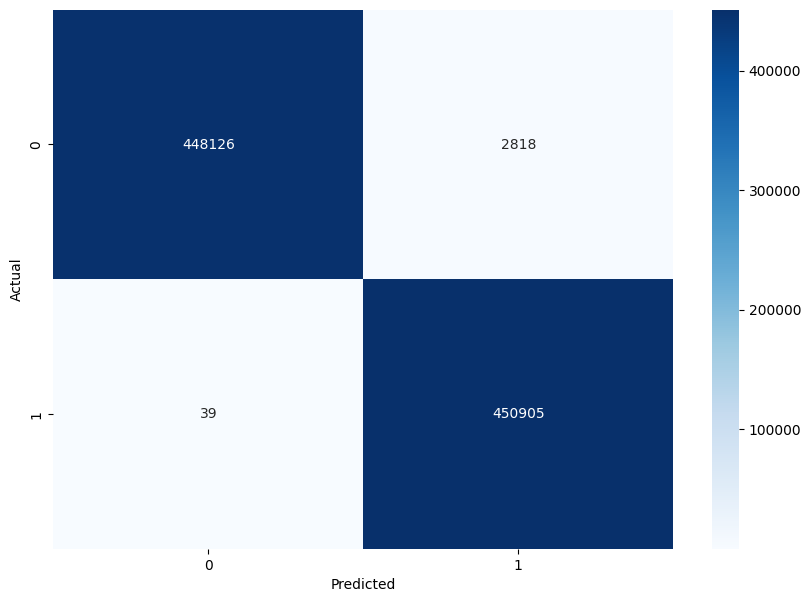

Accuracy:  0.9968322008941243


In [14]:
testing_data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-2/progenitor-pair/testing_data_128.csv')
testing_data = testing_data[select_features]
X_new = testing_data.drop('Is_Progenitor', axis=1)
y_new = testing_data['Is_Progenitor']
X_new_scaled = scaler.transform(X_new)
y_new_pred_prob = model.predict_proba(X_new_scaled)[:, 1]
y_new_pred = binarize(y_new_pred_prob.reshape(1, -1), threshold=0.5)[0]
report = classification_report(y_new, y_new_pred, output_dict=True)
print(report)
cm = confusion_matrix(y_new, y_new_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy = accuracy_score(y_new, y_new_pred)
print('Accuracy: ', accuracy)

In [15]:
df = pd.DataFrame(report).transpose()
df.to_csv('report/random-forest-128-selected-features.csv')

---------

# Merger Trees

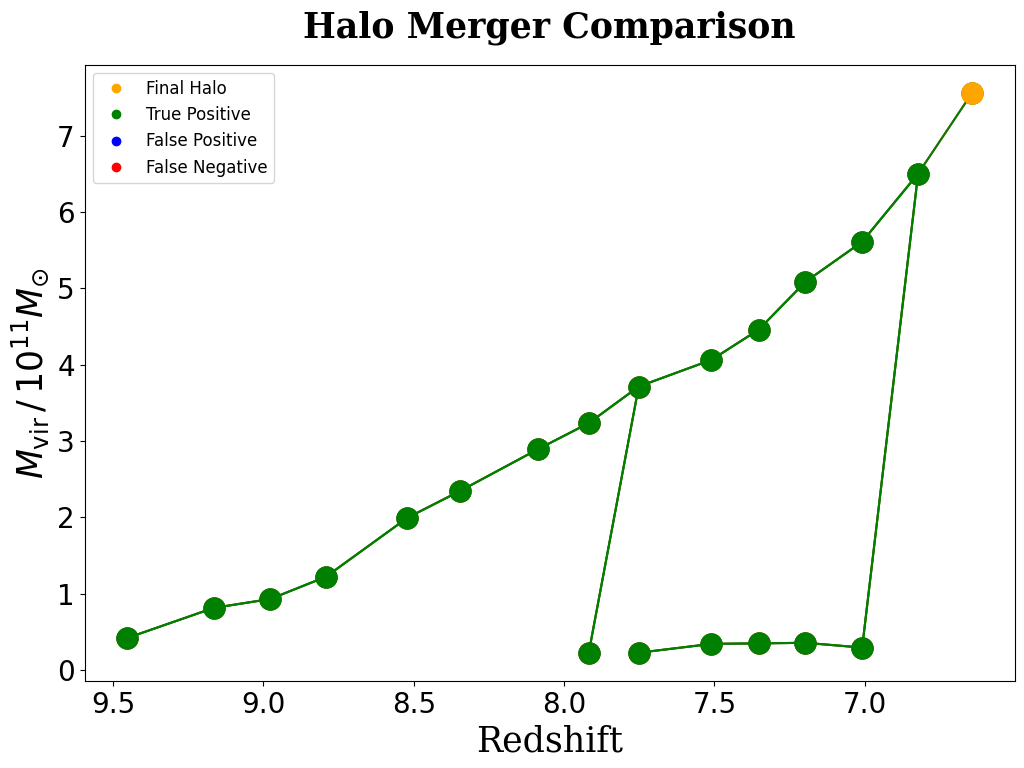

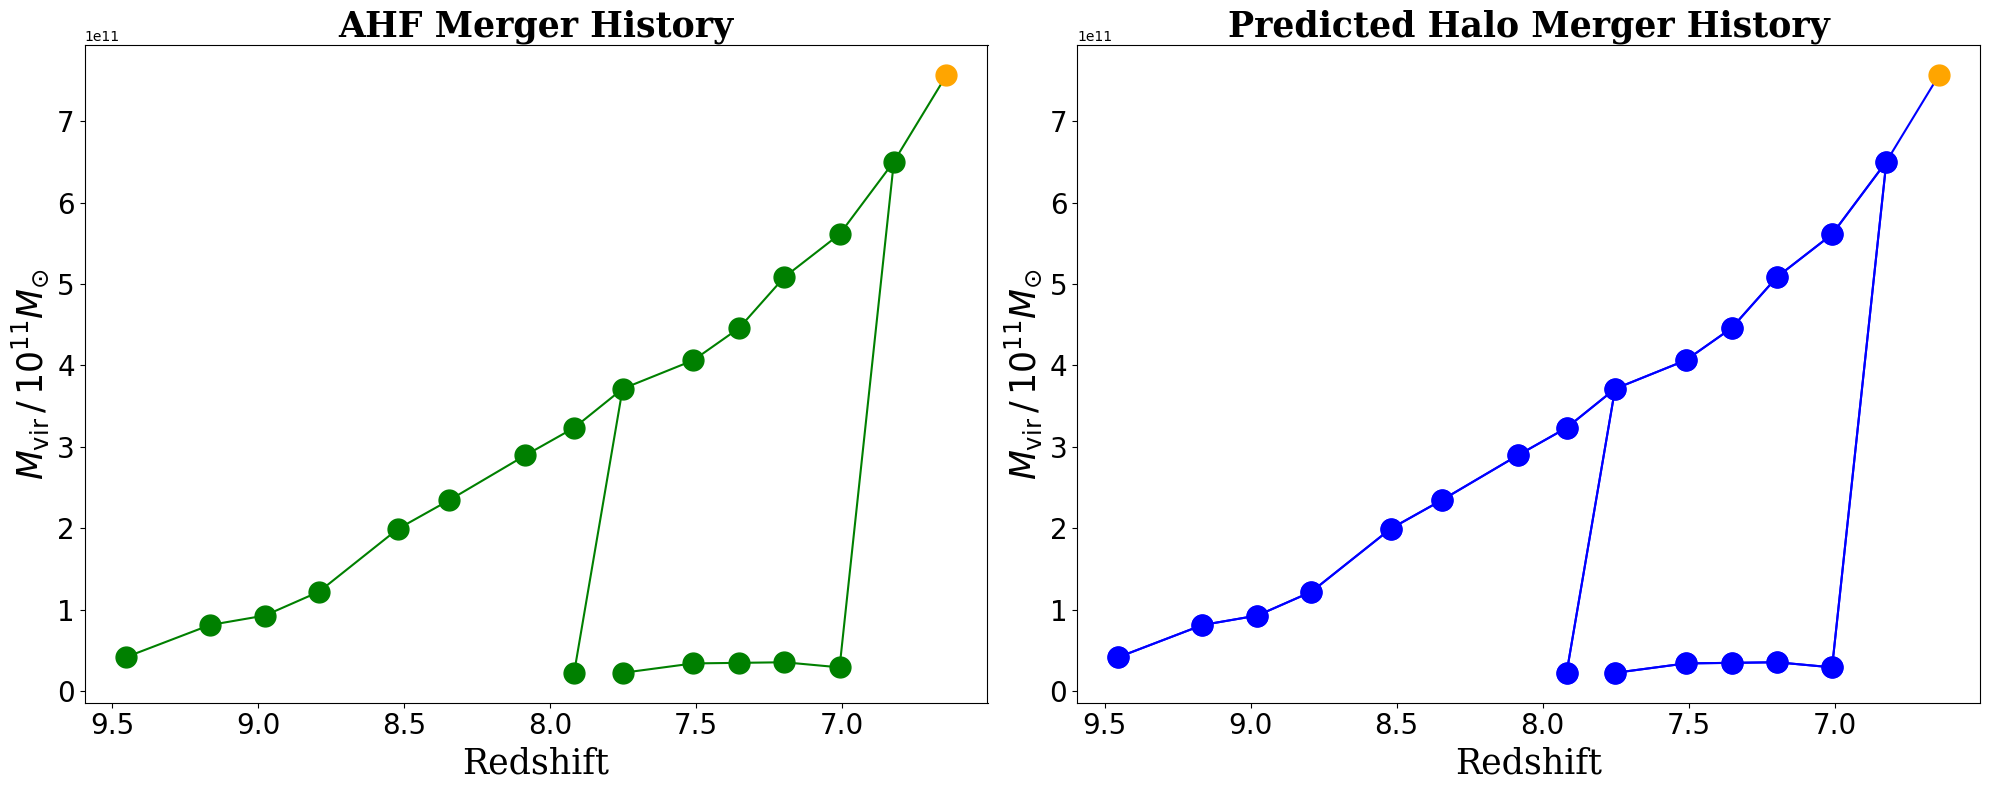

In [16]:
halo = new_data[new_data['ID'] == 36000000000001].iloc[-1] 
halo_id = 36000000000001
snapshot = 36
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger Comparison')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)


In [24]:
predicted_halo_history.to_csv('predicted_halo_history.csv', index=False)
real_halo_history.to_csv('real_halo_history.csv', index=False)

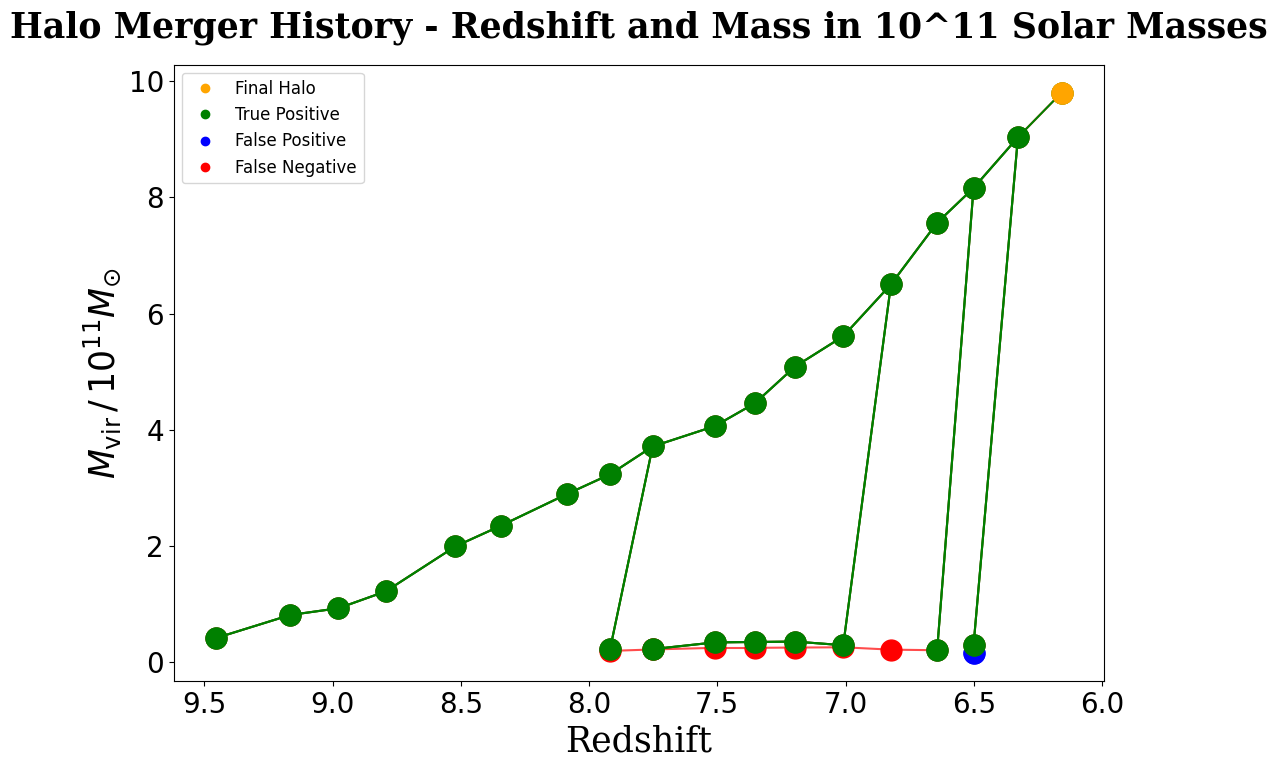

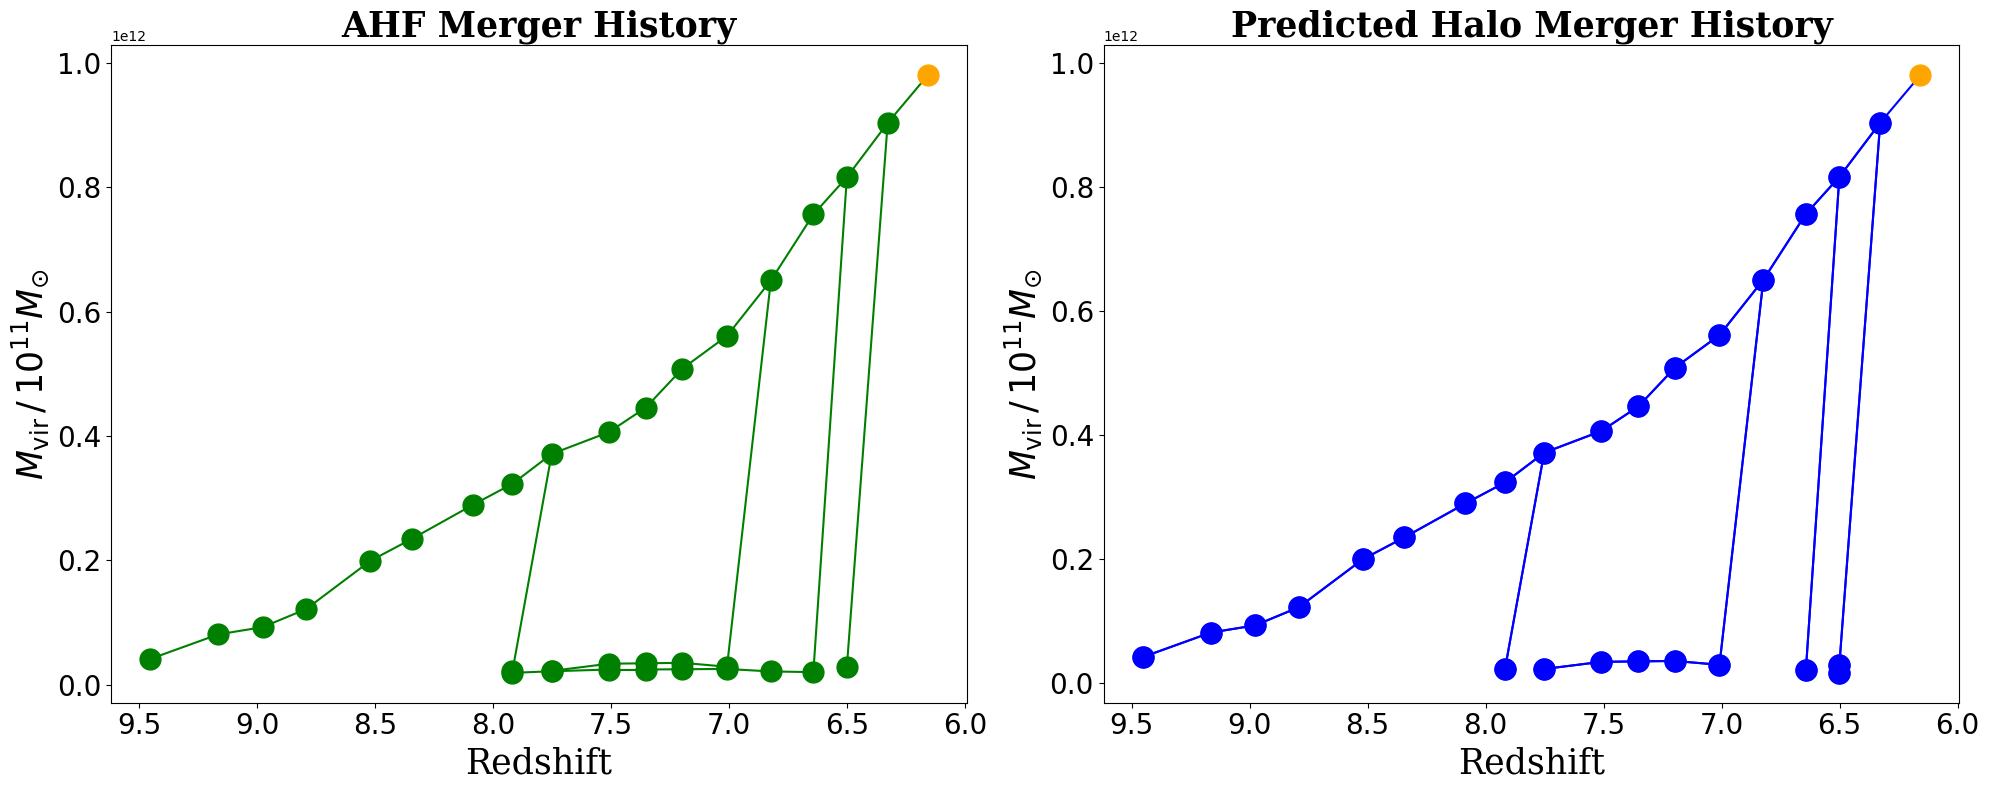

In [17]:
halo = new_data[new_data['ID'] == 39000000000001].iloc[-1] 
halo_id = 39000000000001
snapshot = 39
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

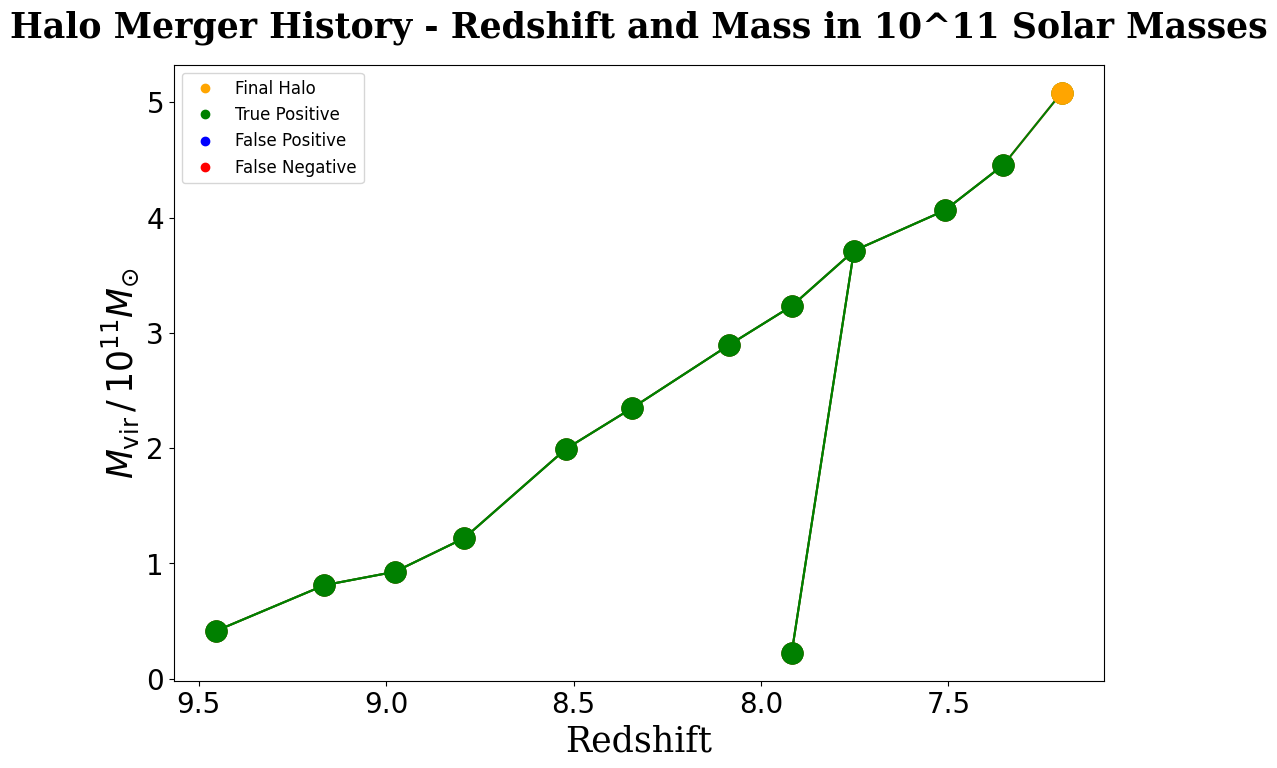

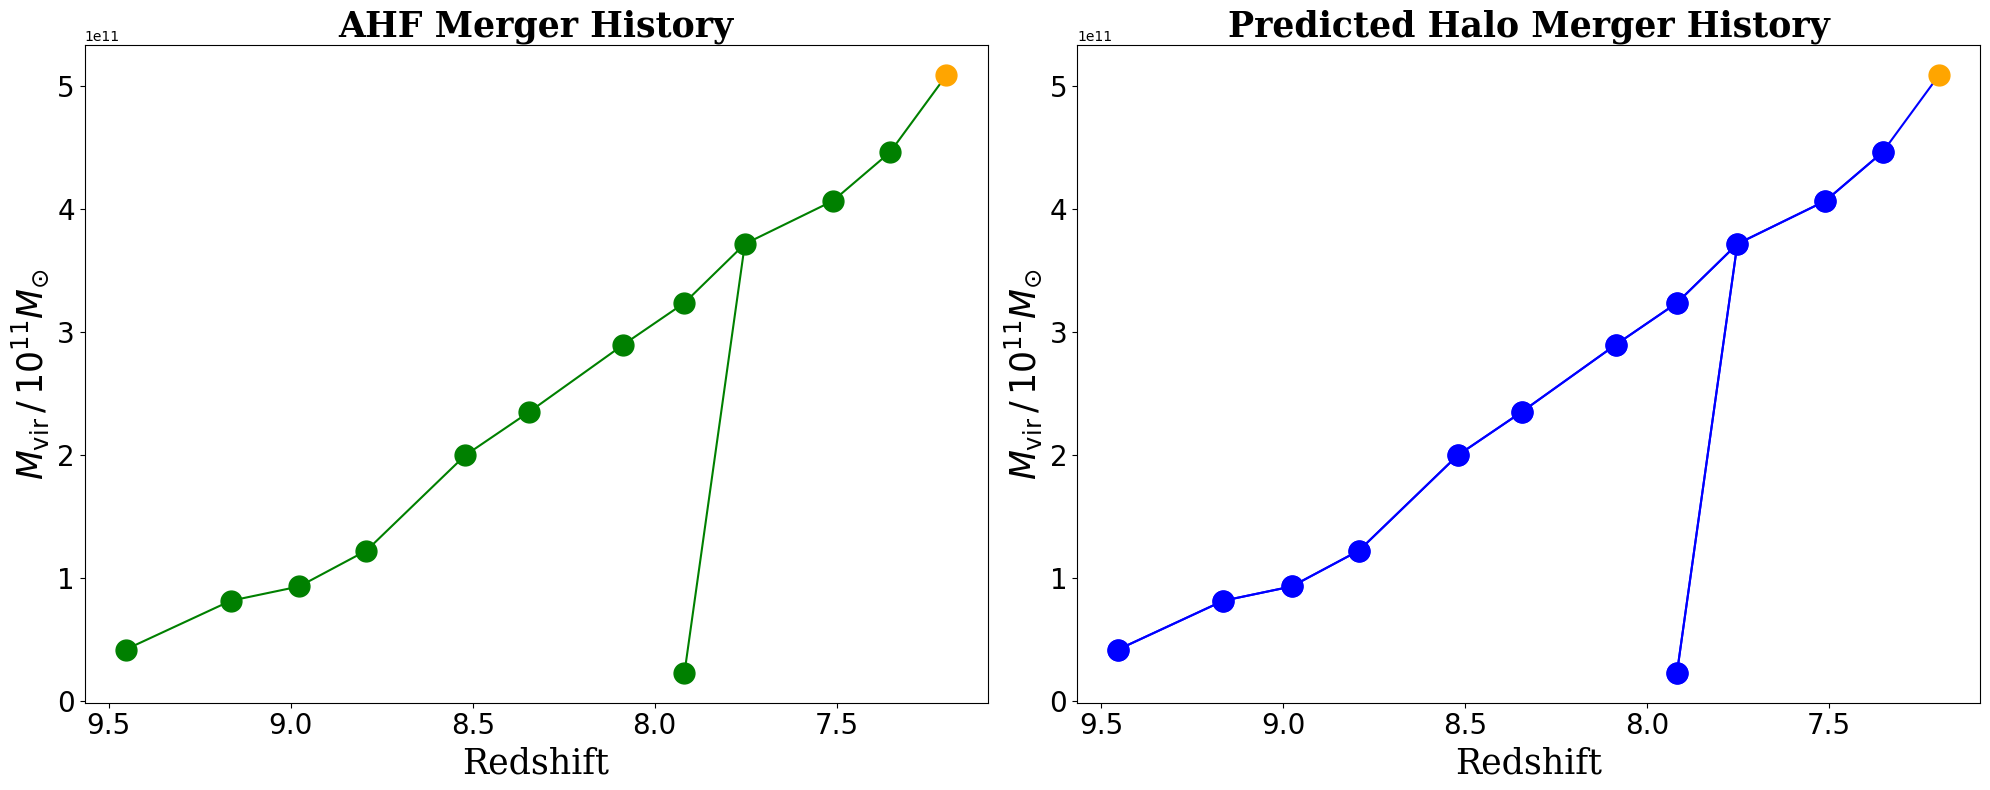

In [18]:
halo = new_data[new_data['ID'] == 33000000000001].iloc[-1] 
halo_id = 33000000000001
snapshot = 33
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

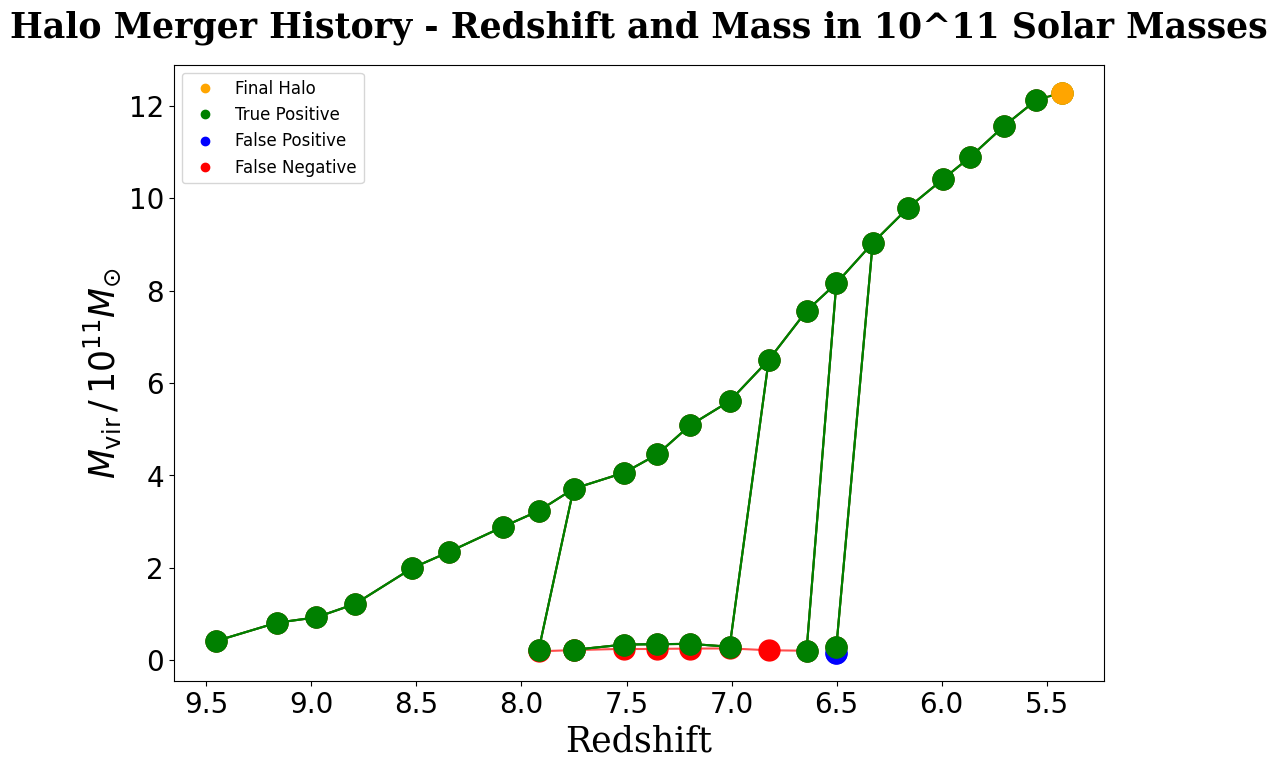

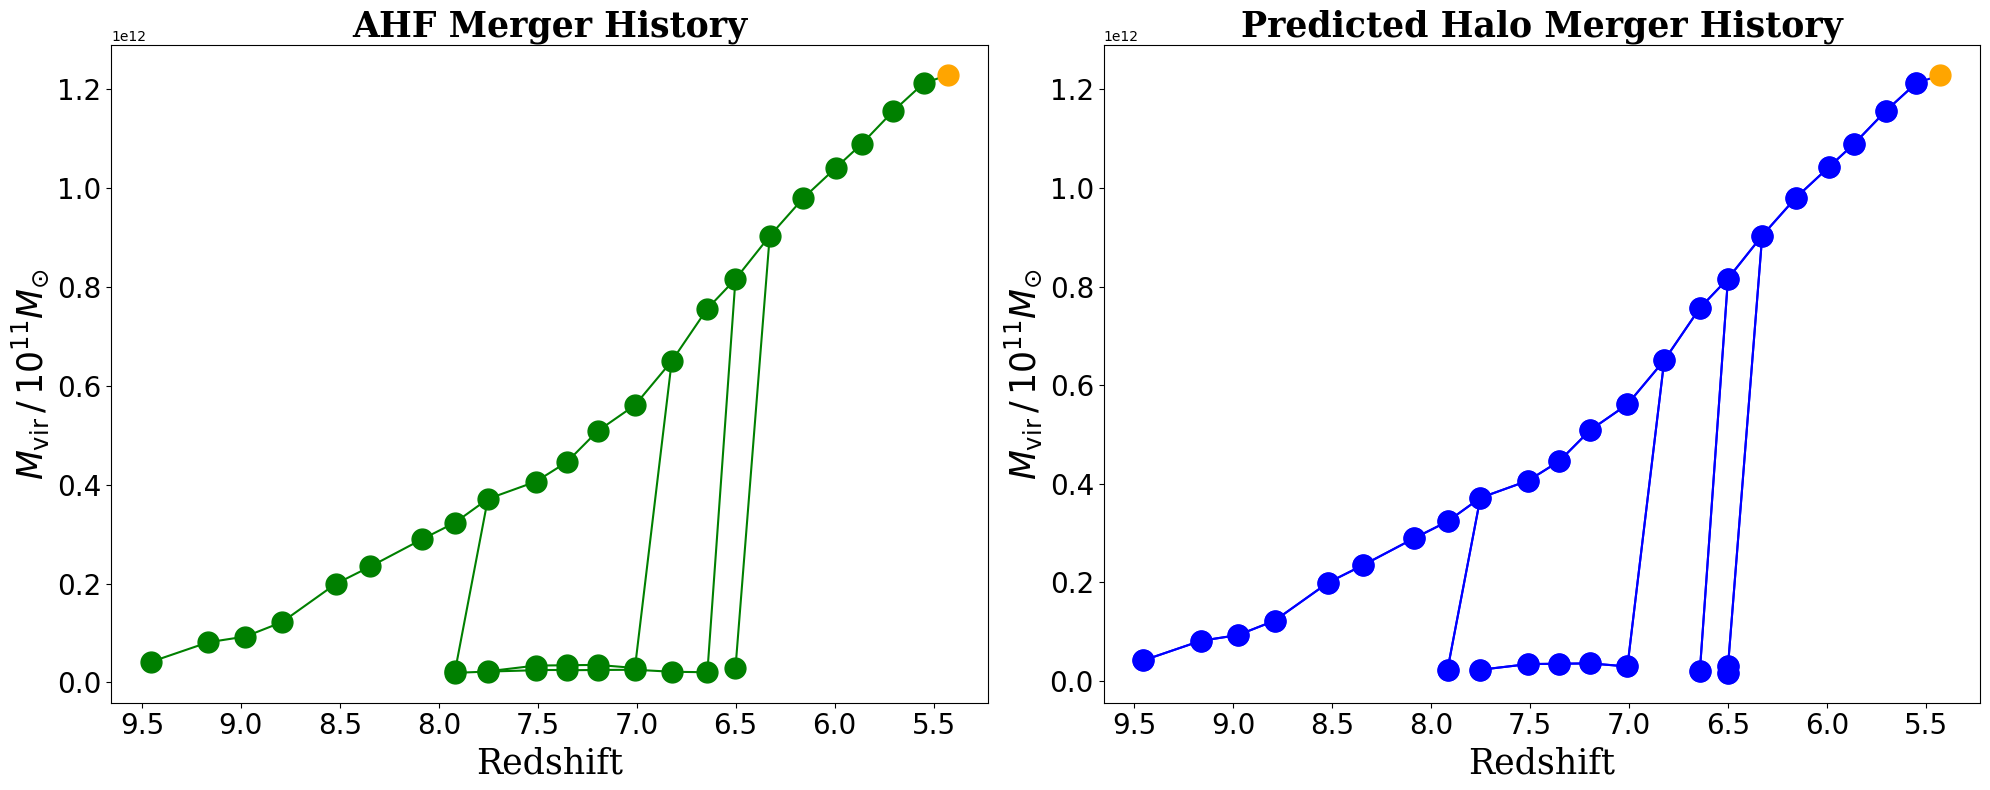

In [26]:
halo = new_data[new_data['ID'] == 44000000000001].iloc[-1] 
halo_id = 44000000000001
snapshot = 44
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

In [50]:
def automate_comparison_with_output(halo_id, new_data, model, scaler, comparison_table):
    # Retrieve the halo and its snapshot
    halo = new_data[new_data['ID'] == halo_id].iloc[-1]
    snapshot = halo['snapshot']
    
    # Track halo histories
    predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
    real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
    
    predicted_df_cleaned_by_id = predicted_halo_history.drop_duplicates(subset=['ID'])
    
    num_predicted_halos_cleaned_by_id = len(predicted_df_cleaned_by_id)
    num_real_halos = len(real_halo_history)
    
    correctly_predicted_by_id = len(set(predicted_df_cleaned_by_id['ID']).intersection(set(real_halo_history['ID'])))
    over_predicted_by_id = num_predicted_halos_cleaned_by_id - correctly_predicted_by_id
    under_predicted_by_id = num_real_halos - correctly_predicted_by_id
    
    merger_rows_predicted = predicted_df_cleaned_by_id[predicted_df_cleaned_by_id['numProgenitors'] > 1]
    merger_snapshots_predicted_list = list(merger_rows_predicted['snapshot'])
    
    merger_rows_real = real_halo_history[real_halo_history['numProgenitors'] > 1]
    merger_snapshots_real_list = list(merger_rows_real['snapshot'])
    
    successful_mergers = len(set(merger_snapshots_predicted_list).intersection(merger_snapshots_real_list))
    total_mergers_predicted = len(set(merger_snapshots_predicted_list))
    
    # Append results to the comparison table
    new_row = {
        'Target Halo ID': halo_id,
        'Total Halos (Predicted)': num_predicted_halos_cleaned_by_id,
        'Total Halos (Real)': num_real_halos,
        'True Positive': correctly_predicted_by_id,
        'False Positive': over_predicted_by_id,
        'False Negative': under_predicted_by_id,
        'Total Merger Events': total_mergers_predicted,
        'Successfully Predicted Merger Events': successful_mergers
    }
    
    # Print the comparison results for the current halo
    print(f"\nResults for Halo ID {halo_id}:")
    for key, value in new_row.items():
        print(f"{key}: {value}")
    
    comparison_table = comparison_table.append(new_row, ignore_index=True)
    
    return comparison_table


def compare_multiple_halos(halo_id_list, new_data, model, scaler, output_file="comparison_results.csv"):
    # Initialize an empty comparison table with the correct columns
    columns = ['Target Halo ID', 'Total Halos (Predicted)', 'Total Halos (Real)', 'True Positive',
               'False Positive', 'False Negative', 'Total Merger Events (Predicted)', 
               'Successfully Predicted Merger Events']

    comparison_table = pd.DataFrame(columns=columns)
    
    total_halos = len(halo_id_list)
    
    # Loop through the list of halo IDs and update the comparison table
    for index, halo_id in enumerate(halo_id_list):
        # Check if the output_file exists and if so, read its content
        existing_halo_ids = set()
        if os.path.exists(output_file):
            existing_data = pd.read_csv(output_file)
            existing_halo_ids = set(existing_data['Target Halo ID'].values)
        
        # Skip the halo if it's already been processed (exists in the CSV file)
        if halo_id in existing_halo_ids:
            print(f"Halo ID {halo_id} already exists in the CSV. Skipping...")
            continue
        
        comparison_table = automate_comparison_with_output(halo_id, new_data, model, scaler, comparison_table)
        
        # Print progress
        print(f"Processed {index+1} out of {total_halos} halo IDs")
        
        # Write the results of the current halo to the CSV file
        comparison_table.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)
        # Clear the comparison table for the next iteration
        comparison_table = pd.DataFrame(columns=columns)
    
    return comparison_table



In [53]:
filtered_data = new_data[(new_data['snapshot'] >= 1) & (new_data['snapshot'] <= 45) & (new_data['numSubStruct'] > 1)]

# Randomly select 100 rows without replacement
random_sample = filtered_data.sample(n=100, random_state=42)  # random_state is for reproducibility

# Extract the halo IDs from these rows
random_halo_ids = random_sample['ID'].values
random_halo_ids


array([34000000000018, 45000000000030, 45000000000012, 39000000000004,
       35000000000001, 42000000000432, 44000000000034, 44000000000103,
       38000000000034, 45000000000032, 43000000000031, 43000000000015,
       45000000000001, 40000000000032, 45000000000295, 42000000000126,
       41000000000012, 40000000000044, 43000000000156, 43000000000018,
       45000000000041, 40000000000045, 42000000000045, 44000000000021,
       44000000000004, 44000000000065, 43000000000023, 41000000000096,
       45000000000073, 40000000000019, 44000000000192, 39000000000042,
       45000000000027, 43000000000097, 38000000000085, 44000000000026,
       43000000000009, 45000000000013, 31000000000021, 40000000000014,
       43000000000003, 44000000000177, 45000000000133, 43000000000279,
       44000000000150, 45000000000022, 43000000000016, 41000000000009,
       41000000000045, 44000000000025, 45000000000424, 39000000000024,
       39000000000212, 44000000000019, 41000000000042, 43000000000044,
      

In [54]:
halo_ids = random_halo_ids
final_table = compare_multiple_halos(halo_ids, new_data, model, scaler, output_file="merger-trees/random-forest-128-selected-features.csv")
final_table


Results for Halo ID 34000000000018:
Target Halo ID: 34000000000018
Total Halos (Predicted): 9
Total Halos (Real): 9
True Positive: 9
False Positive: 0
False Negative: 0
Total Merger Events: 0
Successfully Predicted Merger Events: 0
Processed 1 out of 100 halo IDs

Results for Halo ID 45000000000030:
Target Halo ID: 45000000000030
Total Halos (Predicted): 26
Total Halos (Real): 26
True Positive: 26
False Positive: 0
False Negative: 0
Total Merger Events: 0
Successfully Predicted Merger Events: 0
Processed 2 out of 100 halo IDs

Results for Halo ID 45000000000012:
Target Halo ID: 45000000000012
Total Halos (Predicted): 46
Total Halos (Real): 33
True Positive: 33
False Positive: 13
False Negative: 0
Total Merger Events: 2
Successfully Predicted Merger Events: 2
Processed 3 out of 100 halo IDs

Results for Halo ID 39000000000004:
Target Halo ID: 39000000000004
Total Halos (Predicted): 29
Total Halos (Real): 25
True Positive: 25
False Positive: 4
False Negative: 0
Total Merger Events: 2
Su

,Target Halo ID,Total Halos (Predicted),Total Halos (Real),True Positive,False Positive,False Negative,Total Merger Events (Predicted),Successfully Predicted Merger Events
